# Fake maps to illustrate different features of structure function

We want to show the following:

1. The ideal structure function with the power law and the turnover
2. The effects of seeing and finite map size
3. Effects of inhomogeneous turbulence: decay towards the edges or periodic

In [99]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft
import cmasher as cmr
from matplotlib import pyplot as plt
import turbustat.statistics as tss
import turbustat.simulator
from turbustat.simulator import make_3dfield
from turb_utils import make_extended
import seaborn as sns
import sys
sys.path.append("../muse-strucfunc")
import strucfunc

sns.set_color_codes()
sns.set_context("talk")

In [41]:
r0 = 32.0
N = 256
m = 1.2

In [42]:
def split_square_in_4(arr):
    ny, nx = arr.shape
    assert nx == ny and nx % 2 == 0
    slices = slice(None, nx // 2), slice(nx // 2, None)
    corners = []
    for i, j in [
        (0, 0), (0, 1), (1, 0), (1, 1),
    ]:
        corners.append(arr[slices[i], slices[j]])
    return corners

def normalize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

Function to reduce amplitude of fluctuations towards edge of map.

In [43]:
def taper(arr, scale):
    ny, nx = arr.shape
    xx, yy = np.meshgrid(
        np.linspace(-1.0, 1.0, nx),
        np.linspace(-1.0, 1.0, ny),        
    )
    rr = np.hypot(xx, yy) / scale
    return arr / (1.0 + rr**2)

Function to add a periodic undulation to the fluctuations:

In [128]:
def undulate(arr, wavelength=0.5, angle=45.0 * u.deg, amplitude=1.0):
    ny, nx = arr.shape
    xx, yy = np.meshgrid(
        np.linspace(-1.0, 1.0, nx),
        np.linspace(-1.0, 1.0, ny),        
    )
    ss = xx * np.cos(angle) + yy * np.sin(angle)
    undulation = amplitude * np.sin(2 * np.pi * u.radian * ss / wavelength)
    return arr + undulation

## Idealized fluctuaton field

First we just repeat the previous exercise of making 4 non-periodic fields. The only difference with the previous version is that this time I normalize them all individually, instead of just normalizing the big square before dividing it. 

In [45]:
vms_t = [
    normalize(_) for _ in 
    split_square_in_4(
        make_extended(
            2 * N, powerlaw=2.0 + m, 
            ellip=0.5, theta=45, 
            correlation_length=r0,
            randomseed=2022_02_09,
        )
    )
]

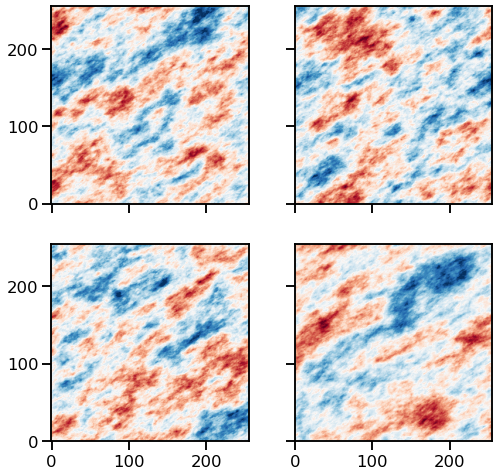

In [46]:
fig, axes = plt.subplots(
    2, 2, 
    sharex=True, sharey=True,
    figsize=(8, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
for vm, ax in zip(vms_t, axes.flat):
    im = ax.imshow(vm, **imshow_kwds)

In [47]:
sfs_npt = [
    strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
    for vm in vms_t
]

../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [48]:
list(sfs_npt[0].keys())

['log10 r',
 'Sum dv^2',
 'Sum weights',
 'Sum w * dv^2',
 'N pairs',
 'Unweighted B(r)',
 'Weighted B(r)']

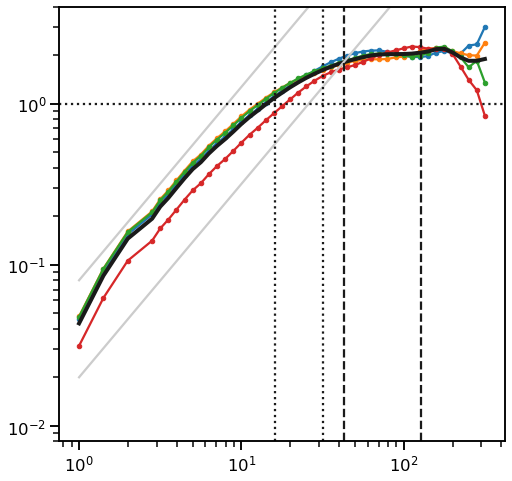

In [49]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sfs_npt[0]["N pairs"] > 0
r = 10**sfs_npt[0]["log10 r"][mask]

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_npt]
Bm = np.mean(np.stack(Bs), axis=0)

for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(r0 / 2, color="k", linestyle="dotted")

ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 4],
);

## Core-dominated fluctuation field

This time, we use the `taper()` function to reduce the amplitude of the fluctuations in the outskirts, but just a bit. 

In [20]:
r0 = 32.0
N = 256
m = 1.2

In [104]:
kernel = Gaussian2DKernel(x_stddev=2.0)
vms_tap = [
    normalize(taper(_, 1.0))
    for _ in 
    split_square_in_4(
        convolve_fft(
            make_extended(
                2 * N, powerlaw=2.0 + m, 
                ellip=0.5, theta=45, 
                correlation_length=r0,
                randomseed=2021_10_08,
            ),
            kernel, 
            boundary="wrap",
        )
    )
]

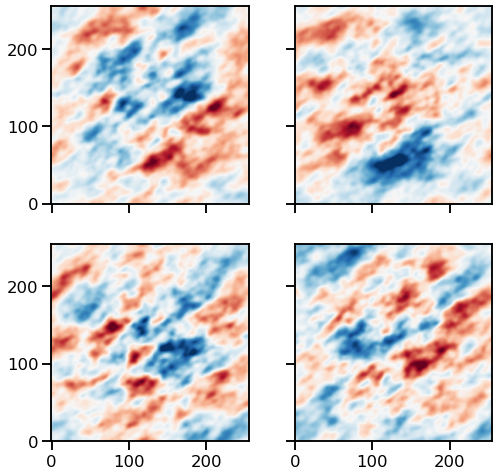

In [105]:
fig, axes = plt.subplots(
    2, 2, 
    sharex=True, sharey=True,
    figsize=(8, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
for vm, ax in zip(vms_tap, axes.flat):
    im = ax.imshow(vm, **imshow_kwds)

So the effect is subtle - it is hard to see it on the above velocity maps.

In [106]:
sfs_tap = [
    strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
    for vm in vms_tap
]

../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


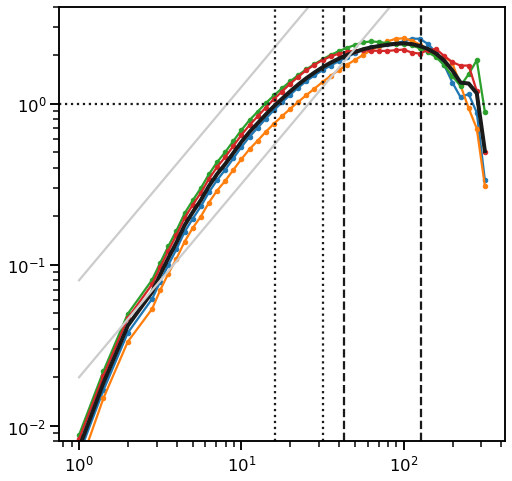

In [107]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sfs_tap[0]["N pairs"] > 0
r = 10**sfs_tap[0]["log10 r"][mask]

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_tap]
Bm = np.mean(np.stack(Bs), axis=0)

for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(r0 / 2, color="k", linestyle="dotted")

ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 4],
);

Nevertheless, we get a strong downwards hook at the largest separations in all 4 structure functions.

## Periodic undulation 

In [108]:
r0 = 32.0
N = 256
m = 1.2

In [129]:
vms_und = [
    normalize(undulate(_, wavelength=1.5, angle=45, amplitude=4.0))
    for _ in 
    split_square_in_4(
        convolve_fft(
            make_extended(
                2 * N, powerlaw=2.0 + m, 
                ellip=0.5, theta=45, 
                correlation_length=r0,
                randomseed=2021_10_08,
            ),
            kernel, 
            boundary="wrap",
        )
     )
]

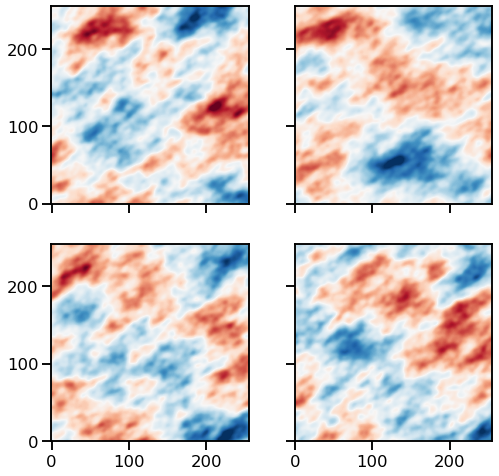

In [130]:
fig, axes = plt.subplots(
    2, 2, 
    sharex=True, sharey=True,
    figsize=(8, 8),
)
imshow_kwds = dict(origin="lower", vmin=-3, vmax=3, cmap="RdBu_r")
for vm, ax in zip(vms_und, axes.flat):
    im = ax.imshow(vm, **imshow_kwds)

In [131]:
sfs_und = [
    strucfunc.strucfunc_numba_parallel(vm, dlogr=0.05)
    for vm in vms_und
]

../muse-strucfunc/strucfunc.py:80: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
../muse-strucfunc/strucfunc.py:81: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


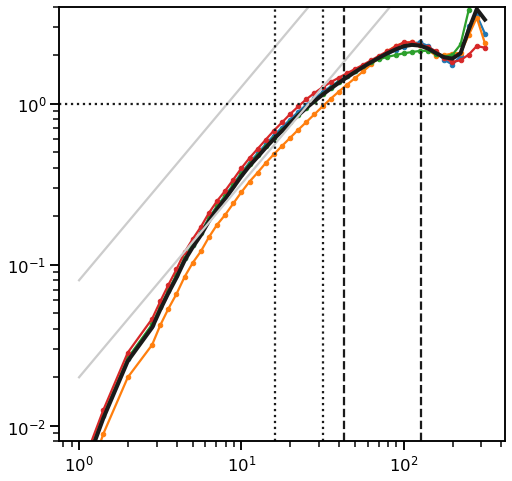

In [132]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)
mask = sfs_und[0]["N pairs"] > 0
r = 10**sfs_und[0]["log10 r"][mask]

Bs = [_["Unweighted B(r)"][mask] for _ in sfs_und]
Bm = np.mean(np.stack(Bs), axis=0)

for _B in Bs:
    ax.plot(r, _B, marker=".")
ax.plot(r, Bm, linewidth=4, color="k")

rgrid = np.logspace(0.0, 2.0)

for scale in 0.02, 0.08:
    ax.plot(rgrid, scale * rgrid**m, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
ax.axvline(r0 / 2, color="k", linestyle="dotted")

ax.axvline(N / 2, color="k", linestyle="dashed")
ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(
    xscale="log", yscale="log",
    ylim=[8e-3, 4],
);